In [159]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from load_data import FD001_dataset
from visualize import visualize


DATA_DIR_PATH = '../CMAPSSData/'
BATCH_SIZE = 10

import plotly.express as px
import plotly.io as pio
# pio.templates.default = "none"
pio.templates.default = "plotly_dark"

N_EPOCH = 100  # NUM OF EPOCHS
RUL_UPPER_BOUND = 130  # UPPER BOUND OF RUL
LR = 0.001  # LEARNING RATE

In [160]:
train_dataset = FD001_dataset(data_type='train', rul_ub=RUL_UPPER_BOUND, norm_type='zscore')
test_dataset = FD001_dataset(data_type='test', rul_ub=RUL_UPPER_BOUND, norm_type='zscore')

In [161]:
# *** Define a padding index for labels ***
# This value MUST be ignored by your loss function.
# For nn.CrossEntropyLoss, use its 'ignore_index' parameter (default -100 is common).
# Choose a value that doesn't conflict with valid label indices/values.
LABEL_PADDING_IDX = -1000000

def pad_collate_fn_time_step_level(batch):
    sequences = [item[0] for item in batch]
    # Labels are also sequences now
    labels = [item[1] for item in batch] # e.g., list of tensors of shape [Li] or [Li, C]
    lengths = torch.tensor([len(seq) for seq in sequences], dtype=torch.long) # Lengths based on input sequences

    # Pad features (input sequences)
    padded_sequences = pad_sequence(sequences, batch_first=True, padding_value=0.0)

    # *** Pad labels (label sequences) ***
    # Use the dedicated label padding index!
    padded_labels = pad_sequence(labels, batch_first=True, padding_value=LABEL_PADDING_IDX)

    return padded_sequences, padded_labels, lengths

# Usage:
# train_loader = DataLoader(..., collate_fn=pad_collate_fn_time_step_level)

In [162]:
def plot_rul_vs_time(unit_nr, model, dataloader):
    """
    Plot the RUL over time for a given unit number.
    """
    X, true_rul = dataloader.dataset[unit_nr - 1]
    
    model.eval()
    predicted_rul = model(X.unsqueeze(0)).detach().numpy().squeeze(0)

    fig = px.line(
        x=np.arange(1, len(true_rul) + 1),
        y=true_rul.reshape(-1),
        title=f'RUL Over Time: Unit {unit_nr}',
        labels={'x': 'Time', 'y': 'RUL'},
        markers=False
    )
    fig.add_scatter(
        x=np.arange(1, len(predicted_rul) + 1),
        y=predicted_rul.reshape(-1),
        mode='lines',
        name='Predicted RUL'
    )
    fig.update_layout(
        legend=dict(yanchor="bottom",
                    y=0.1,
                    xanchor="left",
                    x=0.1)
    )
    fig.show()
    

In [163]:
class RUL_Model(nn.Module):
    """LSTM architecture"""

    def __init__(self, input_size, lstm_hidden_sizes, lstm_layer_sizes, dropout=0.1):
        super(RUL_Model, self).__init__()
        
        assert len(lstm_hidden_sizes) == len(lstm_layer_sizes), "hidden_sizes and layer_sizes must be the same length"
        
        self.input_size = input_size  # input size
        self.lstm_hidden_sizes = lstm_hidden_sizes  # list of hidden sizes
        self.lstm_layer_sizes = lstm_layer_sizes  # number of lstm layers for each hidden size
        self.lstm_stack_size = sum(lstm_layer_sizes)  # total number of lstm layers

        self.lstm_list = self.create_lstm_stack()
        self.fc_1 = nn.Linear(self.lstm_hidden_sizes[-1], 8)  # fully connected 1
        self.fc_2 = nn.Linear(8, 8)  # fully connected 2
        self.fc = nn.Linear(8, 1)  # fully connected last layer

        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()
        
    def create_lstm_stack(self):
        """Create LSTM stack based on hidden sizes and layer sizes"""
        lstm_list = nn.ModuleList()
        input_size = self.input_size
        for hidden_size, num_layers in zip(self.lstm_hidden_sizes, self.lstm_layer_sizes):
            lstm_list.append(nn.LSTM(input_size, 
                                     hidden_size, 
                                     num_layers, 
                                     batch_first=True))
            input_size = hidden_size
        return lstm_list

    def forward(self, x, lengths=None):
        """
        Forward pass through the LSTM stack and fully connected layers.
        :param x: input features
        :return: prediction results
        """
        input = pack_padded_sequence(x,
                                     lengths.cpu(), 
                                     batch_first=True, 
                                     enforce_sorted=False) if lengths is not None else x
        packed_lstm_outs = [input]
        for lstm in self.lstm_list:
            packed_lstm_outs.append(lstm(packed_lstm_outs[-1])[0])
            
        lstm_outs = [pad_packed_sequence(out,
                                         batch_first=True,
                                         padding_value=0.0,
                                         total_length=x.size(1))[0] for out in packed_lstm_outs] if lengths is not None else packed_lstm_outs
        
        out_1 = self.relu(self.fc_1(lstm_outs[-1]))
        out_2 = self.relu(self.fc_2(out_1))
        out_dp = self.dropout(out_2)
        out = self.fc(out_dp)
        
        return out #, (hn, cn), out_1, out_2, out_dp, output

<h2>No shuffle, L2Reg | Yes Dropout</h2>

In [164]:
train_dataLoader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=pad_collate_fn_time_step_level)
test_dataLoader = DataLoader(test_dataset, batch_size=1, shuffle=False) 

In [165]:
model = RUL_Model(input_size=train_dataLoader.dataset[0][0].shape[1], lstm_hidden_sizes=[32, 64], lstm_layer_sizes=[1, 1], dropout=0.1)
loss_fn = torch.nn.MSELoss(reduction='none')  # mean-squared error for regression
# optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
optimizer = torch.optim.RMSprop(model.parameters(), lr=LR)

# Just to use the original visualisation module
y_test = pd.DataFrame({"RUL": [y[:, -1, :].item() for _, y in test_dataLoader]})

Epoch   1/100 | Training... 100 Train Loss: 1997155.2200, Validation Loss: 83.9527
Epoch   2/100 | Training... 100 Train Loss: 1927704.6700, Validation Loss: 82.0183
Epoch   3/100 | Training... 100 Train Loss: 1838990.3700, Validation Loss: 79.3174
Epoch   4/100 | Training... 100 Train Loss: 1708925.7600, Validation Loss: 75.4484
Epoch   5/100 | Training... 100 Train Loss: 1558810.9100, Validation Loss: 71.3633


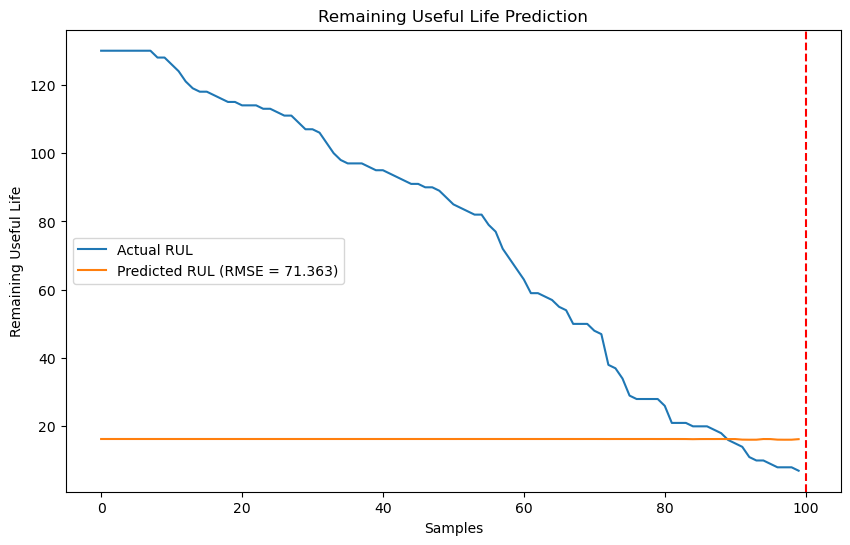

Epoch   6/100 | Training... 100 Train Loss: 1409379.7400, Validation Loss: 67.1703
Epoch   7/100 | Training... 100 Train Loss: 1263584.4800, Validation Loss: 62.9452
Epoch   8/100 | Training... 100 Train Loss: 1124380.7900, Validation Loss: 58.7939
Epoch   9/100 | Training... 100 Train Loss: 993614.5700, Validation Loss: 54.8081
Epoch  10/100 | Training... 100 Train Loss: 873573.3000, Validation Loss: 50.4581


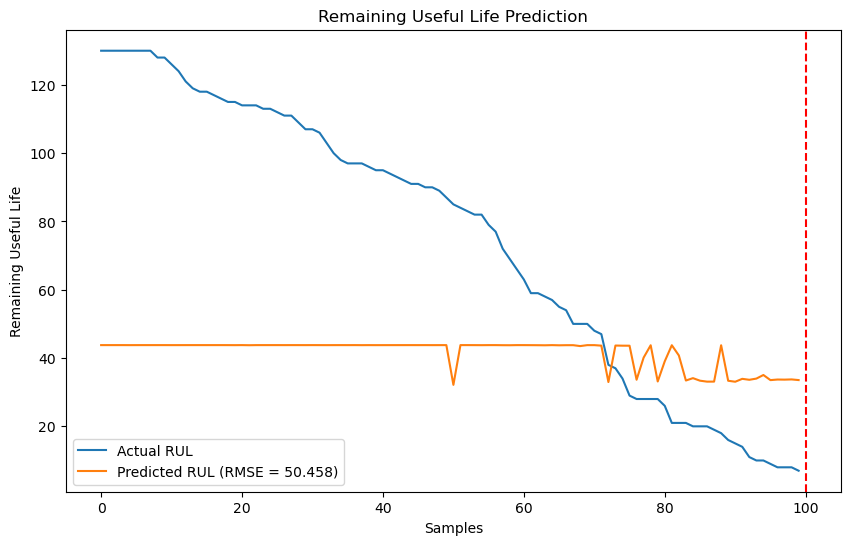

Epoch  11/100 | Training... 100 Train Loss: 748015.7950, Validation Loss: 45.8474
Epoch  12/100 | Training... 100 Train Loss: 636613.8550, Validation Loss: 41.8557
Epoch  13/100 | Training... 100 Train Loss: 542261.3750, Validation Loss: 38.0245
Epoch  14/100 | Training... 100 Train Loss: 459132.1150, Validation Loss: 34.6893
Epoch  15/100 | Training... 100 Train Loss: 388903.4450, Validation Loss: 31.3117


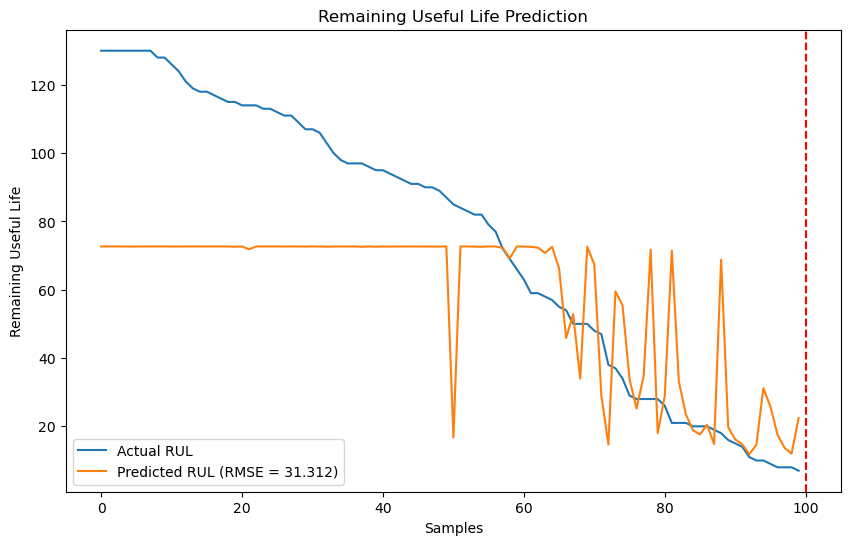

Epoch  16/100 | Training... 100 Train Loss: 327302.9300, Validation Loss: 28.2182
Epoch  17/100 | Training... 100 Train Loss: 281139.9875, Validation Loss: 25.3523
Epoch  18/100 | Training... 100 Train Loss: 239682.0988, Validation Loss: 22.9011
Epoch  19/100 | Training... 100 Train Loss: 205831.7888, Validation Loss: 20.7079
Epoch  20/100 | Training... 100 Train Loss: 181554.5575, Validation Loss: 19.9464


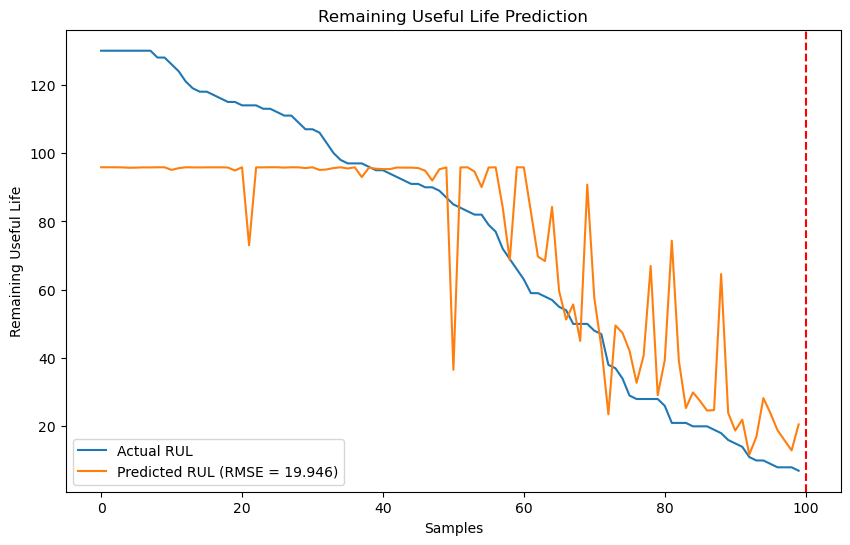

Epoch  21/100 | Training... 100 Train Loss: 165016.6525, Validation Loss: 18.1679
Epoch  22/100 | Training... 100 Train Loss: 148982.2487, Validation Loss: 17.0377
Epoch  23/100 | Training... 100 Train Loss: 137488.2000, Validation Loss: 16.8823
Epoch  24/100 | Training... 100 Train Loss: 133797.3400, Validation Loss: 16.6808
Epoch  25/100 | Training... 100 Train Loss: 123296.5181, Validation Loss: 16.7465


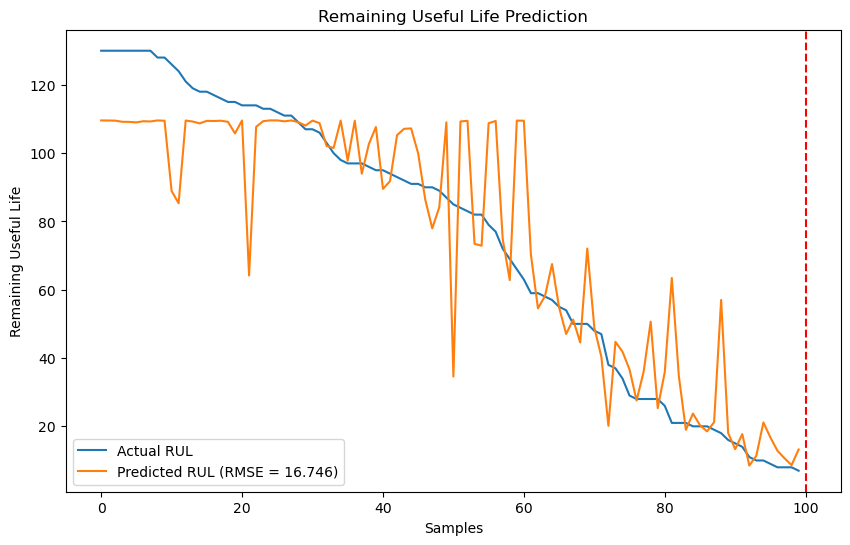

Epoch  26/100 | Training... 100 Train Loss: 123537.0862, Validation Loss: 16.7800
Epoch  27/100 | Training... 100 Train Loss: 116551.5631, Validation Loss: 16.5271
Epoch  28/100 | Training... 100 Train Loss: 114620.0594, Validation Loss: 16.4931
Epoch  29/100 | Training... 100 Train Loss: 110435.6156, Validation Loss: 16.4475
Epoch  30/100 | Training... 100 Train Loss: 108205.8550, Validation Loss: 16.2212


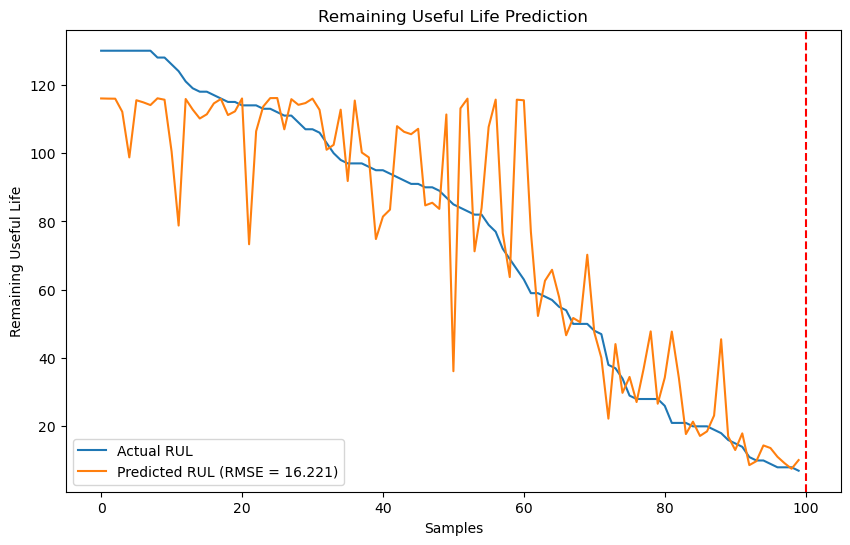

Epoch  31/100 | Training... 100 Train Loss: 105220.4138, Validation Loss: 16.3807
Epoch  32/100 | Training... 100 Train Loss: 102171.0156, Validation Loss: 16.0868
Epoch  33/100 | Training... 100 Train Loss: 100935.6638, Validation Loss: 16.0615
Epoch  34/100 | Training... 100 Train Loss: 100191.0163, Validation Loss: 16.1298
Epoch  35/100 | Training... 100 Train Loss: 97780.0575, Validation Loss: 15.9643


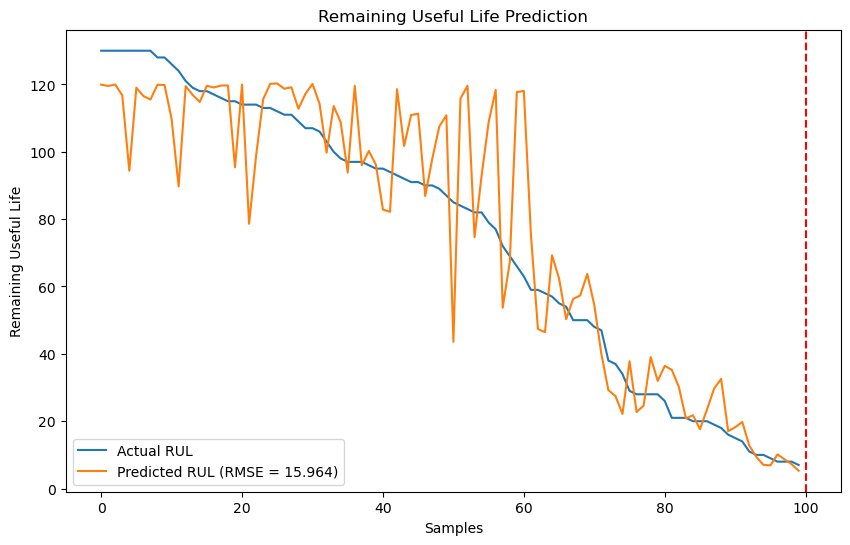

Epoch  36/100 | Training... 100 Train Loss: 96592.6638, Validation Loss: 16.5050
Epoch  37/100 | Training... 100 Train Loss: 91701.7437, Validation Loss: 16.0526
Epoch  38/100 | Training... 100 Train Loss: 93903.9825, Validation Loss: 16.5461
Epoch  39/100 | Training... 100 Train Loss: 91763.1044, Validation Loss: 16.6710
Epoch  40/100 | Training... 100 Train Loss: 91635.9275, Validation Loss: 16.0980


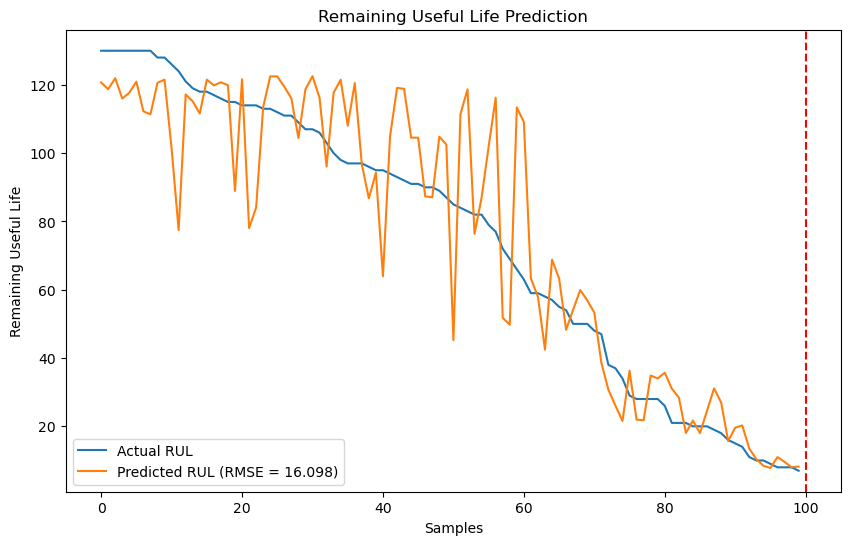

Epoch  41/100 | Training... 100 Train Loss: 88688.5312, Validation Loss: 15.9491
Epoch  42/100 | Training... 100 Train Loss: 87373.2894, Validation Loss: 15.7453
Epoch  43/100 | Training... 100 Train Loss: 88222.5975, Validation Loss: 15.9705
Epoch  44/100 | Training... 100 Train Loss: 85934.1050, Validation Loss: 15.7918
Epoch  45/100 | Training... 100 Train Loss: 81725.3431, Validation Loss: 16.1483


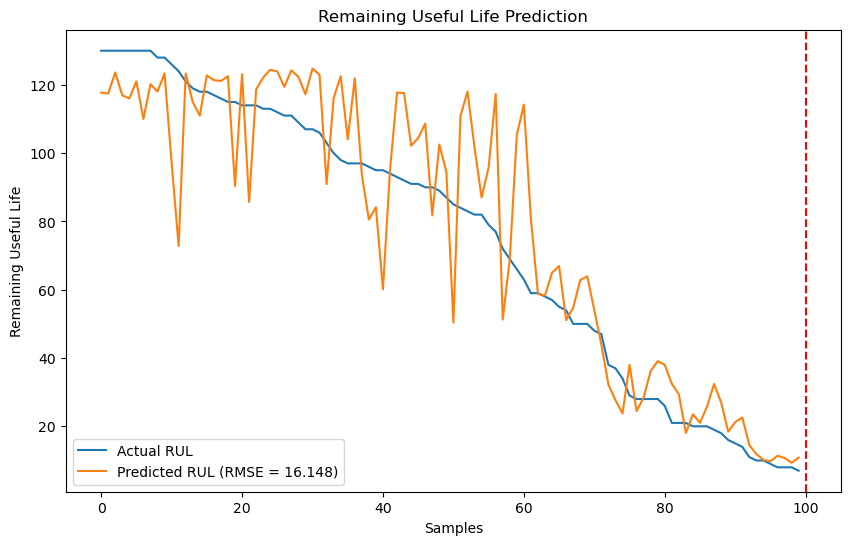

Epoch  46/100 | Training... 100 Train Loss: 81336.5494, Validation Loss: 15.6400
Epoch  47/100 | Training... 100 Train Loss: 90479.4738, Validation Loss: 15.5324
Epoch  48/100 | Training... 100 Train Loss: 82297.9250, Validation Loss: 15.5770
Epoch  49/100 | Training... 100 Train Loss: 79537.9381, Validation Loss: 16.8486
Epoch  50/100 | Training... 100 Train Loss: 77494.9962, Validation Loss: 16.5936


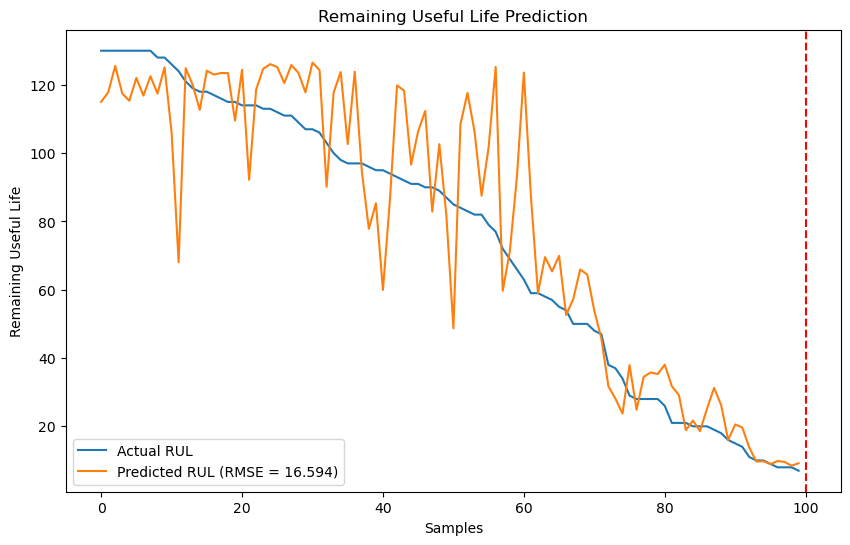

Epoch  51/100 | Training... 100 Train Loss: 84786.7675, Validation Loss: 16.6980
Epoch  52/100 | Training... 100 Train Loss: 79166.3125, Validation Loss: 15.9785
Epoch  53/100 | Training... 100 Train Loss: 81343.3131, Validation Loss: 16.3794
Epoch  54/100 | Training... 100 Train Loss: 78159.3225, Validation Loss: 16.2017
Epoch  55/100 | Training... 100 Train Loss: 81301.4125, Validation Loss: 16.4132


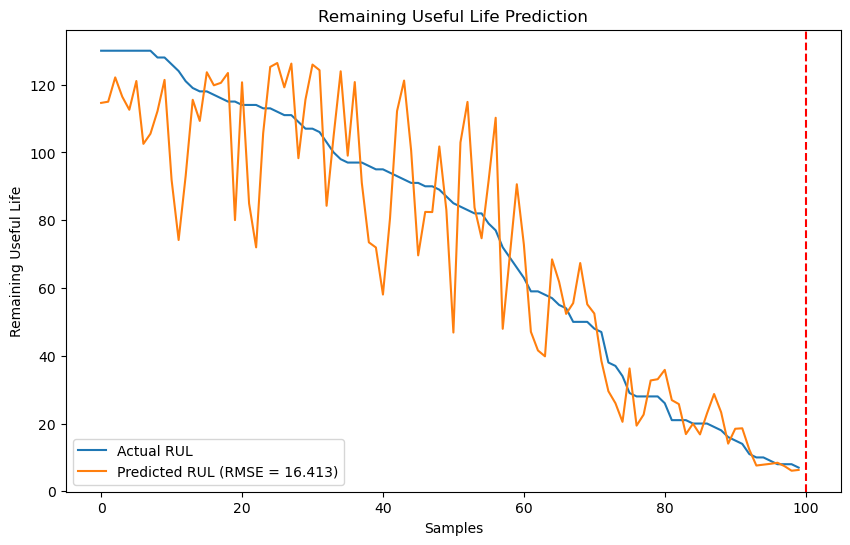

Epoch  56/100 | Training... 100 Train Loss: 79877.3556, Validation Loss: 15.7664
Epoch  57/100 | Training... 100 Train Loss: 77542.9325, Validation Loss: 15.4671
Epoch  58/100 | Training... 100 Train Loss: 80192.0544, Validation Loss: 15.5181
Epoch  59/100 | Training... 100 Train Loss: 77286.5650, Validation Loss: 15.9079
Epoch  60/100 | Training... 100 Train Loss: 75575.5137, Validation Loss: 15.9796


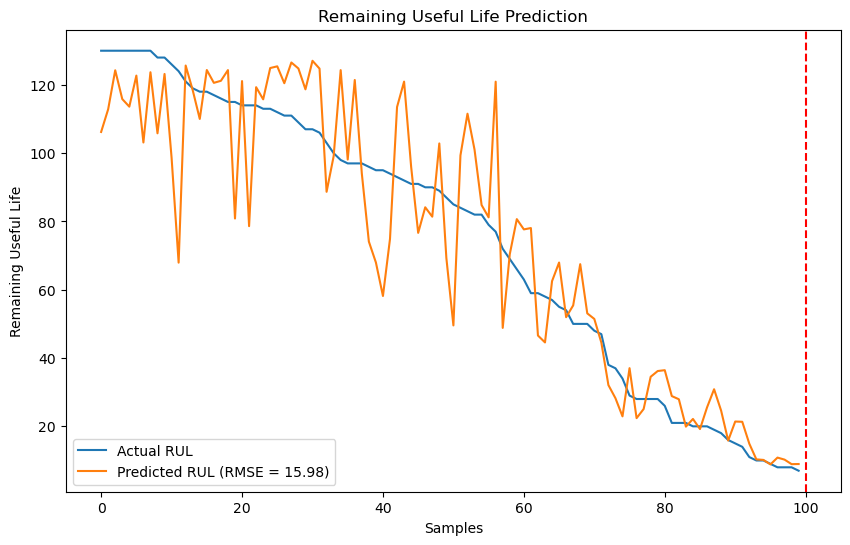

Epoch  61/100 | Training... 100 Train Loss: 74141.7962, Validation Loss: 16.5397
Epoch  62/100 | Training... 100 Train Loss: 74996.1950, Validation Loss: 15.1316
Epoch  63/100 | Training... 100 Train Loss: 77060.0112, Validation Loss: 15.6280
Epoch  64/100 | Training... 100 Train Loss: 74862.3262, Validation Loss: 15.8096
Epoch  65/100 | Training... 100 Train Loss: 75911.4144, Validation Loss: 15.8868


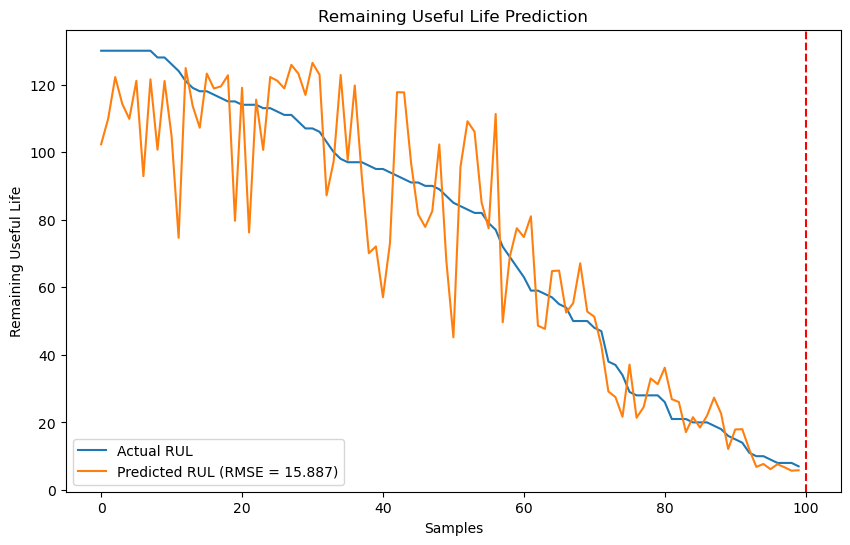

Epoch  66/100 | Training... 100 Train Loss: 75951.4569, Validation Loss: 17.4845
Epoch  67/100 | Training... 100 Train Loss: 78689.2269, Validation Loss: 16.4111
Epoch  68/100 | Training... 100 Train Loss: 75027.7444, Validation Loss: 16.4860
Epoch  69/100 | Training... 100 Train Loss: 74391.7650, Validation Loss: 16.4990
Epoch  70/100 | Training... 100 Train Loss: 73308.5725, Validation Loss: 15.8499


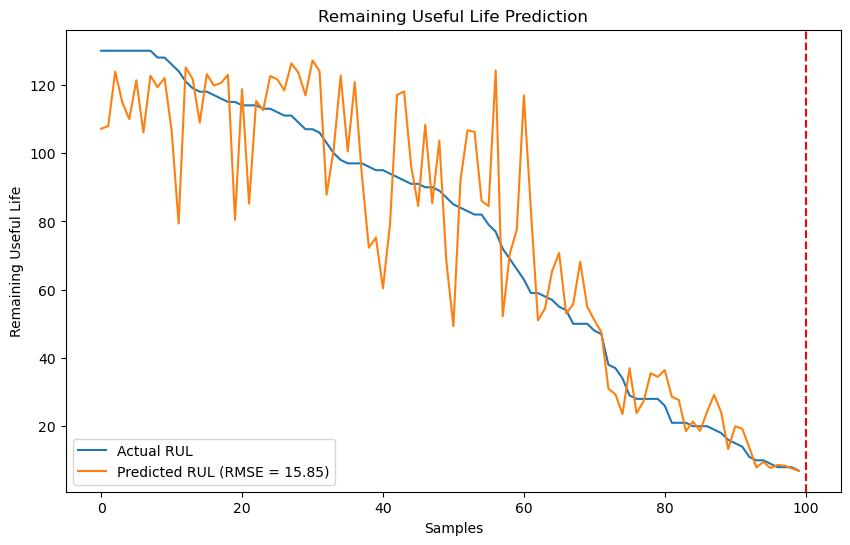

Epoch  71/100 | Training... 100 Train Loss: 72829.7531, Validation Loss: 17.1663
Epoch  72/100 | Training... 100 Train Loss: 76687.5594, Validation Loss: 16.5134
Epoch  73/100 | Training... 100 Train Loss: 75432.0694, Validation Loss: 20.2602
Epoch  74/100 | Training... 100 Train Loss: 85513.6888, Validation Loss: 15.8495
Epoch  75/100 | Training... 100 Train Loss: 78140.0044, Validation Loss: 15.5885


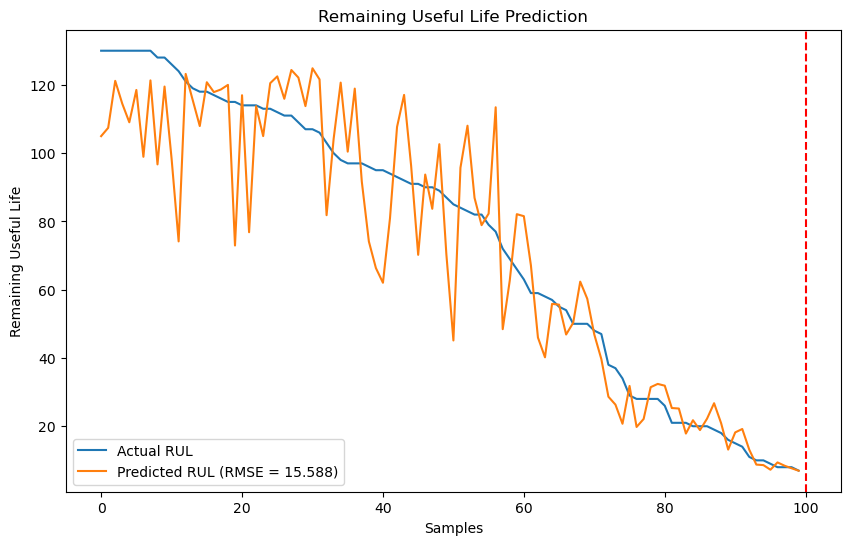

Epoch  76/100 | Training... 100

KeyboardInterrupt: 

In [166]:
prev_val_loss = 1000000
for epoch in range(1, N_EPOCH + 1):
    model.train()
    train_loss = 0
    print(f"Epoch {epoch: 3}/{N_EPOCH} | Training...   ", end="")
    for i, (x_padSeq, y_padSeq, original_seq_lens) in enumerate(train_dataLoader):
        print(f"\b\b{(i+1)*BATCH_SIZE:02}", end='')
        optimizer.zero_grad()
        y_pred = model(x_padSeq, original_seq_lens)
        loss_elementwise = loss_fn(y_pred, y_padSeq)
        
        # --- Masked Loss Calculation --- ALL THIS IS BEING DONE TO FACILITATE BATCHING
        # 1. Create the mask (True/1 for non-padded, False/0 for padded)
        max_len = y_pred.size(1) # Get max sequence length from output/target
        # Create range tensor [0, 1, ..., max_len-1] on the correct device
        indices = torch.arange(max_len).expand(x_padSeq.size(0), -1) # Shape: [batch, max_len]
        # Create mask by comparing indices with lengths (broadcast lengths)
        mask = (indices < original_seq_lens.unsqueeze(1)).unsqueeze(-1) # Shape: [batch, max_len] (boolean)

        masked_loss = loss_elementwise * mask
        total_loss = torch.sum(masked_loss)
        # mean_loss = total_loss / torch.sum(mask)  # Mean loss over non-padded elements
        
        total_loss.backward()
        optimizer.step()
        train_loss += total_loss.item()
    train_loss /= len(train_dataLoader.dataset)

    #### VALIDATION ####    
    model.eval()
    val_loss = 0
    val_results = []
    with torch.no_grad():
        for i, (x, y) in enumerate(test_dataLoader):
            y_pred = model(x)
            val_loss = np.add(np.power((y_pred[:, -1, :].item() - y[:, -1, :].item()), 2), val_loss)
            val_results.append(y_pred[:, -1, :].item())
    val_loss = (np.sqrt(val_loss / len(test_dataLoader.dataset))).item()
    
    if val_loss > prev_val_loss and prev_val_loss < 15:
        print("Early stopping")
        break
    else:
        prev_val_loss = val_loss
        torch.save(model.state_dict(), f'best_model.pth')    
    
    if epoch % 1 == 0:
        print(f" Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")
        # print(f"Test Results: {test_results}")
        if epoch % 5 == 0:
            visualize(val_results, y_test, 100, val_loss)

In [139]:
plot_rul_vs_time(unit_nr=49, model=model, dataloader=test_dataLoader)

<h2>LSTM with Learnable Initial States</h2>

In [167]:
class RUL_Model_LearnableInputs(nn.Module):
    """LSTM architecture"""

    def __init__(self, input_size, lstm_hidden_sizes, lstm_layer_sizes, dropout=0.1):
        super(RUL_Model_LearnableInputs, self).__init__()
        
        assert len(lstm_hidden_sizes) == len(lstm_layer_sizes), "hidden_sizes and layer_sizes must be the same length"
        
        self.input_size = input_size  # input size
        self.lstm_hidden_sizes = lstm_hidden_sizes  # list of hidden sizes
        self.lstm_layer_sizes = lstm_layer_sizes  # number of lstm layers for each hidden size
        self.lstm_stack_size = sum(lstm_layer_sizes)  # total number of lstm layers

        self.lstm_list = self.create_lstm_stack()
        self.initial_state_list = self.create_learnable_initial_states()
        self.fc_1 = nn.Linear(self.lstm_hidden_sizes[-1], 8)  # fully connected 1
        self.fc_2 = nn.Linear(8, 8)  # fully connected 2
        self.fc = nn.Linear(8, 1)  # fully connected last layer

        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()
        
    def create_lstm_stack(self):
        """Create LSTM stack based on hidden sizes and layer sizes"""
        lstm_list = nn.ModuleList()
        input_size = self.input_size
        for hidden_size, num_layers in zip(self.lstm_hidden_sizes, self.lstm_layer_sizes):
            lstm_list.append(nn.LSTM(input_size, 
                                     hidden_size, 
                                     num_layers, 
                                     batch_first=True))
            input_size = hidden_size
        return lstm_list
    
    def create_learnable_initial_states(self):
        initial_states = nn.ParameterList()
        for hidden_size, num_layers in zip(self.lstm_hidden_sizes, self.lstm_layer_sizes):
            h0 = nn.Parameter(torch.zeros(num_layers, 1, hidden_size))
            c0 = nn.Parameter(torch.zeros(num_layers, 1, hidden_size))
            initial_states.append((h0, c0))
        return initial_states
        

    def forward(self, x, lengths=None):
        """
        Forward pass through the LSTM stack and fully connected layers.
        :param x: input features
        :return: prediction results
        """
        batch_size = x.size(0)
        input = pack_padded_sequence(x,
                                     lengths.cpu(), 
                                     batch_first=True, 
                                     enforce_sorted=False) if lengths is not None else x
        packed_lstm_outs = [input]
        for lstm, (h0, c0) in zip(self.lstm_list, self.initial_state_list):
            h0_batch = h0.expand(-1, batch_size, -1).contiguous()
            c0_batch = c0.expand(-1, batch_size, -1).contiguous()
            packed_lstm_outs.append(lstm(packed_lstm_outs[-1], (h0_batch, c0_batch))[0])
            
        lstm_outs = [pad_packed_sequence(out,
                                         batch_first=True,
                                         padding_value=0.0,
                                         total_length=x.size(1))[0] for out in packed_lstm_outs] if lengths is not None else packed_lstm_outs
        
        out_1 = self.relu(self.fc_1(lstm_outs[-1]))
        out_2 = self.relu(self.fc_2(out_1))
        out_dp = self.dropout(out_2)
        out = self.fc(out_dp)
        
        return out #, (hn, cn), out_1, out_2, out_dp, output

In [170]:
model = RUL_Model_LearnableInputs(input_size=train_dataLoader.dataset[0][0].shape[1], lstm_hidden_sizes=[32, 64], lstm_layer_sizes=[1, 1], dropout=0.1)
loss_fn = torch.nn.MSELoss(reduction='none')  # mean-squared error for regression
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
# optimizer = torch.optim.RMSprop(model.parameters(), lr=LR)

# Just to use the original visualisation module
y_test = pd.DataFrame({"RUL": [y[:, -1, :].item() for _, y in test_dataLoader]})

Epoch 1/100 | Training... 100 Train Loss: 2020472.1600, Validation Loss: 85.4034
Epoch 2/100 | Training... 100 Train Loss: 2018882.8200, Validation Loss: 85.3641
Epoch 3/100 | Training... 100 Train Loss: 2017746.5300, Validation Loss: 85.3477
Epoch 4/100 | Training... 100 Train Loss: 2017263.4000, Validation Loss: 85.3387
Epoch 5/100 | Training... 100 Train Loss: 2016903.8000, Validation Loss: 85.3299


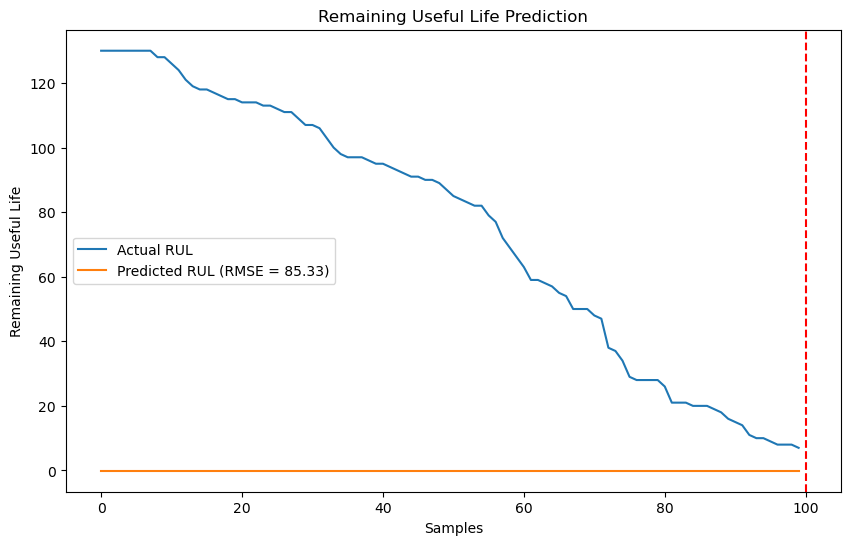

Epoch 6/100 | Training... 100 Train Loss: 2016529.5000, Validation Loss: 85.3212
Epoch 7/100 | Training... 100 Train Loss: 2016165.2800, Validation Loss: 85.3124
Epoch 8/100 | Training... 100 Train Loss: 2015798.1000, Validation Loss: 85.3037
Epoch 9/100 | Training... 100 Train Loss: 2015431.6000, Validation Loss: 85.2949
Epoch 10/100 | Training... 100 Train Loss: 2015042.6600, Validation Loss: 85.2803


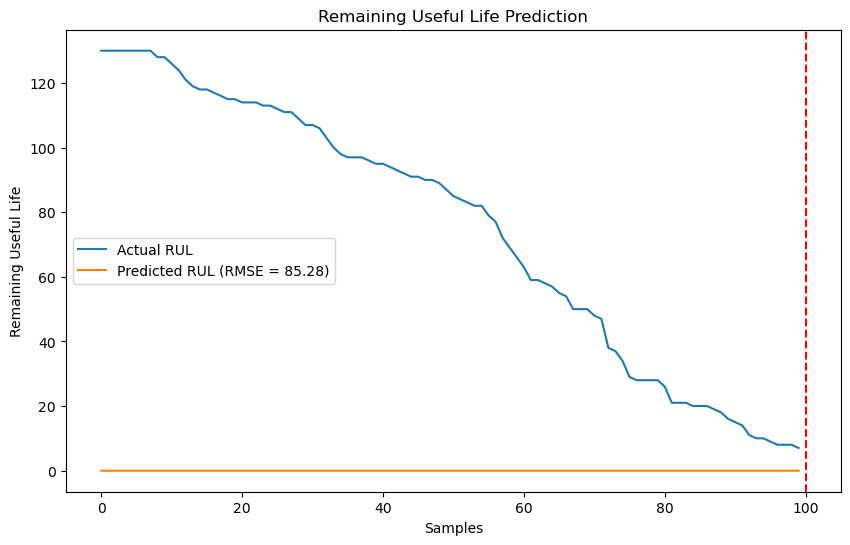

Epoch 11/100 | Training... 100 Train Loss: 2013593.8800, Validation Loss: 85.2113
Epoch 12/100 | Training... 100 Train Loss: 2009375.4200, Validation Loss: 85.0451
Epoch 13/100 | Training... 100 Train Loss: 1999366.9000, Validation Loss: 84.7187
Epoch 14/100 | Training... 100 Train Loss: 1983629.6000, Validation Loss: 84.2643
Epoch 15/100 | Training... 100 Train Loss: 1962891.3300, Validation Loss: 83.6954


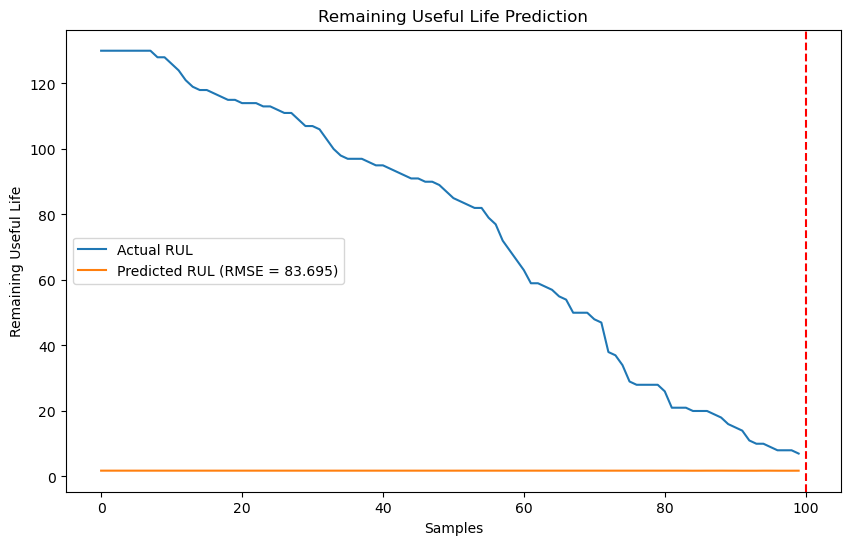

Epoch 16/100 | Training... 100 Train Loss: 1937007.5000, Validation Loss: 82.9637
Epoch 17/100 | Training... 100 Train Loss: 1901956.4700, Validation Loss: 81.9589
Epoch 18/100 | Training... 100 Train Loss: 1858037.5500, Validation Loss: 80.7012
Epoch 19/100 | Training... 100 Train Loss: 1802981.9500, Validation Loss: 79.1954
Epoch 20/100 | Training... 100 Train Loss: 1739512.0400, Validation Loss: 77.4142


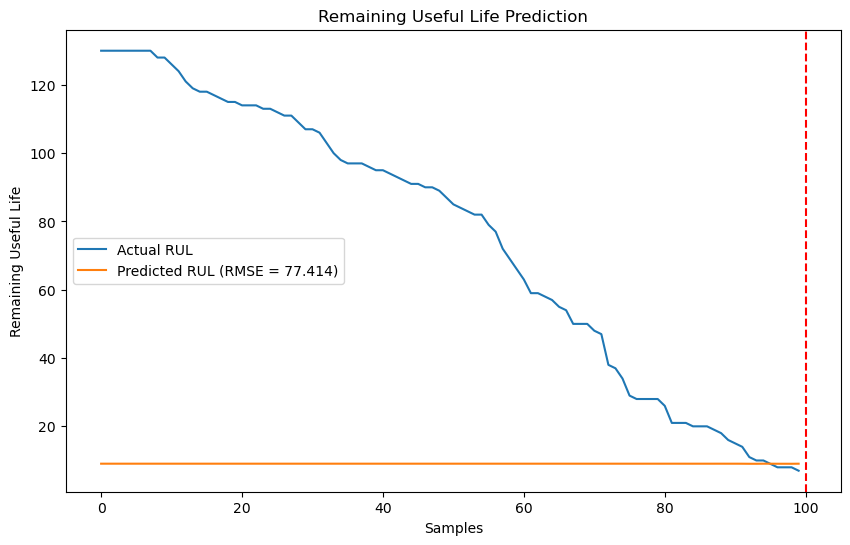

Epoch 21/100 | Training... 100 Train Loss: 1666101.4100, Validation Loss: 75.3661
Epoch 22/100 | Training... 100 Train Loss: 1585326.7300, Validation Loss: 73.0676
Epoch 23/100 | Training... 100 Train Loss: 1496288.0700, Validation Loss: 70.5171
Epoch 24/100 | Training... 100 Train Loss: 1401342.6500, Validation Loss: 67.7333
Epoch 25/100 | Training... 100 Train Loss: 1302644.7700, Validation Loss: 64.7955


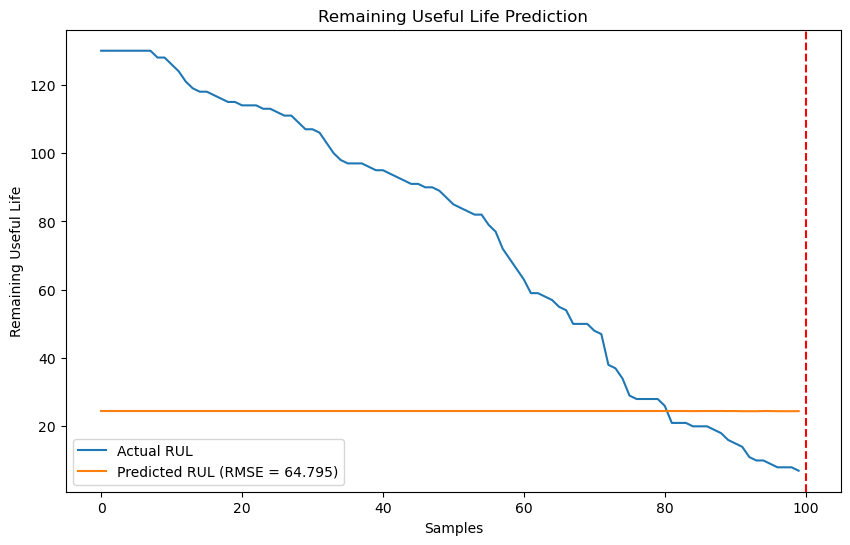

Epoch 26/100 | Training... 100 Train Loss: 1201288.1900, Validation Loss: 61.7038
Epoch 27/100 | Training... 100 Train Loss: 1098574.4200, Validation Loss: 58.5268
Epoch 28/100 | Training... 100 Train Loss: 1002825.3150, Validation Loss: 55.3578
Epoch 29/100 | Training... 100 Train Loss: 906250.4050, Validation Loss: 52.3140
Epoch 30/100 | Training... 100 Train Loss: 818986.7450, Validation Loss: 49.4325


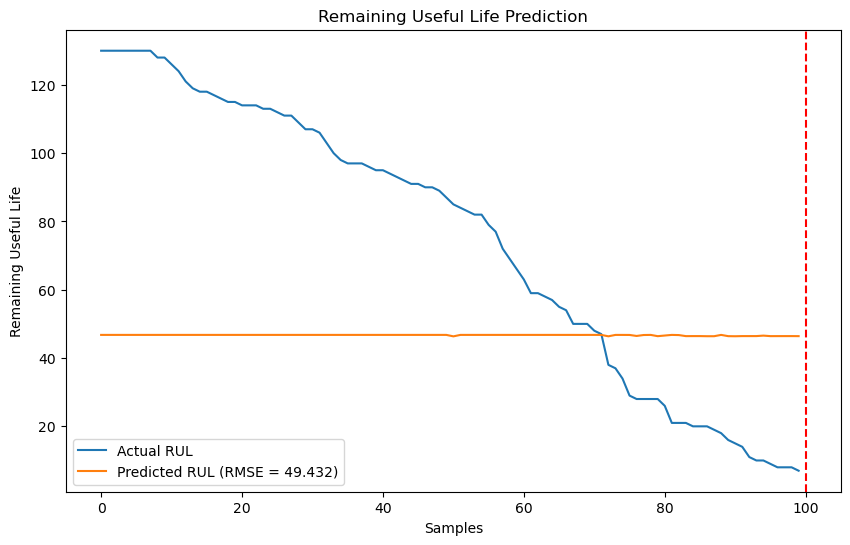

Epoch 31/100 | Training... 100 Train Loss: 738268.8850, Validation Loss: 46.6479
Epoch 32/100 | Training... 100 Train Loss: 661270.3100, Validation Loss: 42.4189
Epoch 33/100 | Training... 100 Train Loss: 559741.3250, Validation Loss: 38.4717
Epoch 34/100 | Training... 100 Train Loss: 482818.7225, Validation Loss: 35.1655
Epoch 35/100 | Training... 100 Train Loss: 416914.2700, Validation Loss: 32.1298


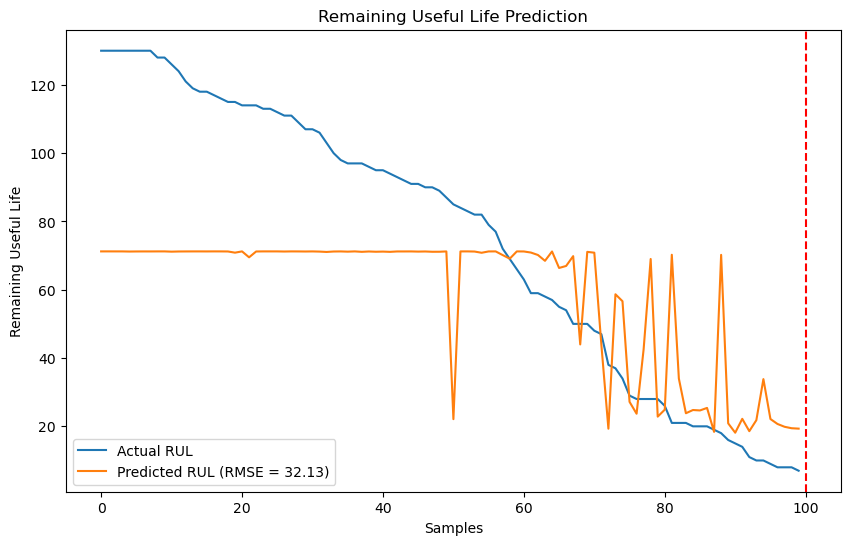

Epoch 36/100 | Training... 100 Train Loss: 358667.8900, Validation Loss: 29.0543
Epoch 37/100 | Training... 100 Train Loss: 311583.1275, Validation Loss: 26.2473
Epoch 38/100 | Training... 100 Train Loss: 273887.2850, Validation Loss: 23.9515
Epoch 39/100 | Training... 100 Train Loss: 239862.2087, Validation Loss: 21.8927
Epoch 40/100 | Training... 100 Train Loss: 214102.1313, Validation Loss: 19.6872


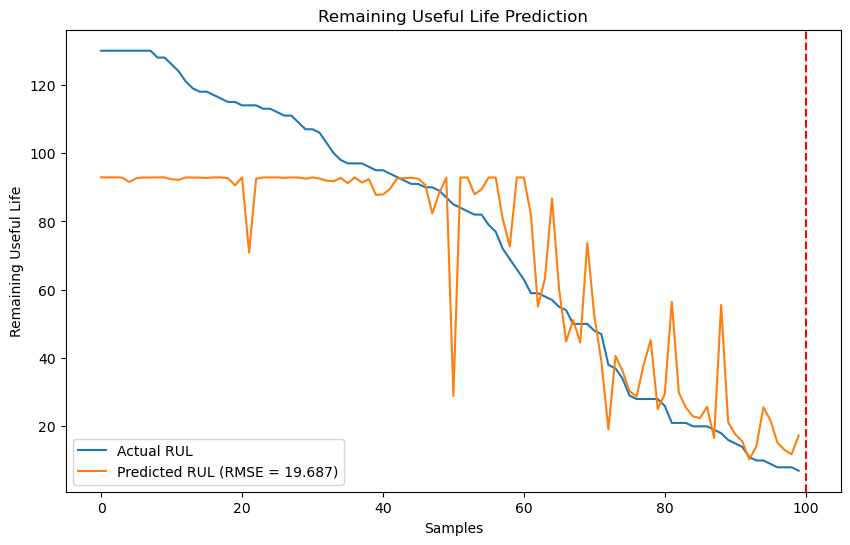

Epoch 41/100 | Training... 100 Train Loss: 190435.1913, Validation Loss: 19.2207
Epoch 42/100 | Training... 100 Train Loss: 177565.7362, Validation Loss: 17.3211
Epoch 43/100 | Training... 100 Train Loss: 162170.5125, Validation Loss: 17.1570
Epoch 44/100 | Training... 100 Train Loss: 153637.4937, Validation Loss: 15.8024
Epoch 45/100 | Training... 100 Train Loss: 147992.1925, Validation Loss: 16.1857


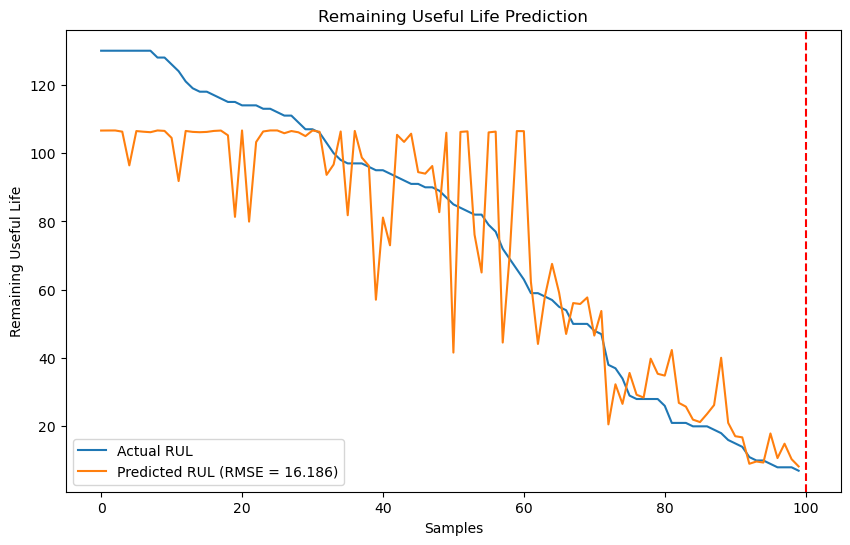

Epoch 46/100 | Training... 100 Train Loss: 143145.9250, Validation Loss: 17.0445
Epoch 47/100 | Training... 100 Train Loss: 137371.9138, Validation Loss: 16.2971
Epoch 48/100 | Training... 100 Train Loss: 136236.8400, Validation Loss: 16.8967
Epoch 49/100 | Training... 100 Train Loss: 134405.7400, Validation Loss: 17.7281
Epoch 50/100 | Training... 100 Train Loss: 131640.8844, Validation Loss: 15.1522


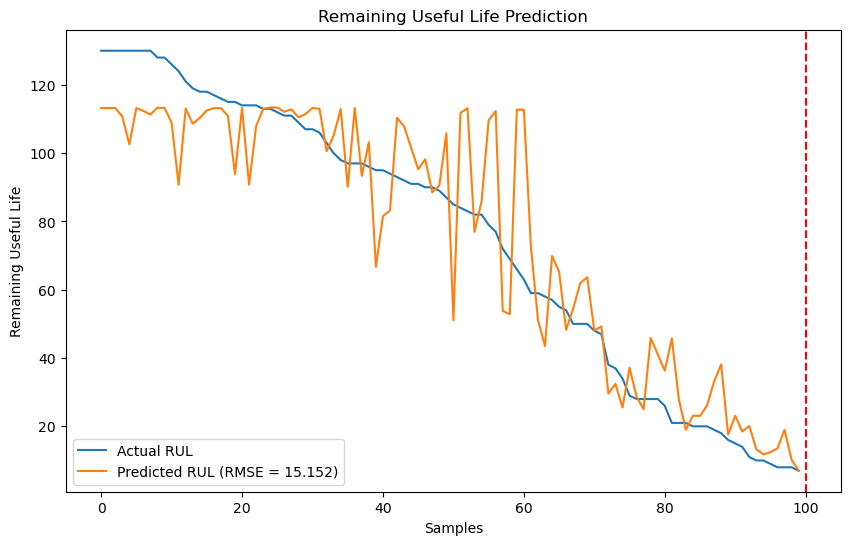

Epoch 51/100 | Training... 100 Train Loss: 126644.4175, Validation Loss: 15.2065
Epoch 52/100 | Training... 100 Train Loss: 126178.5681, Validation Loss: 17.0707
Epoch 53/100 | Training... 100 Train Loss: 120305.6731, Validation Loss: 16.6691
Epoch 54/100 | Training... 100 Train Loss: 126621.2375, Validation Loss: 16.0997
Epoch 55/100 | Training... 100 Train Loss: 119144.4419, Validation Loss: 16.3056


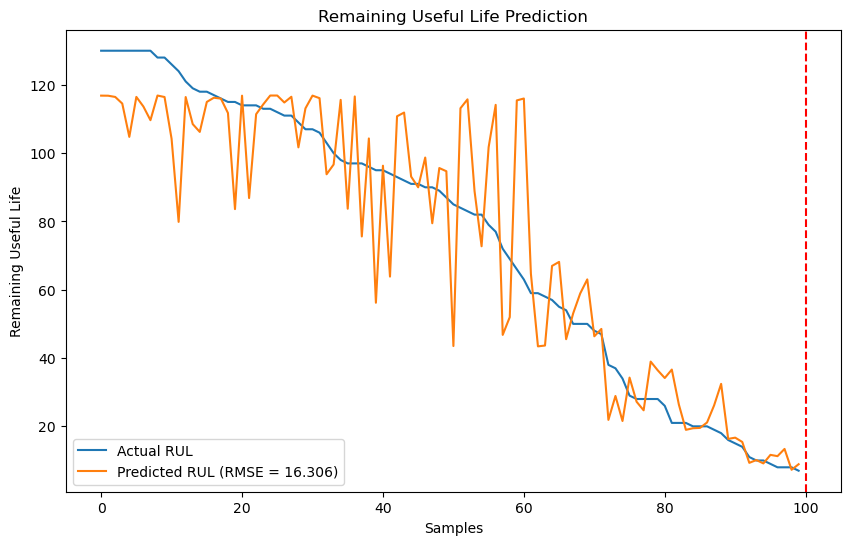

Epoch 56/100 | Training... 100 Train Loss: 119326.1669, Validation Loss: 16.2183
Epoch 57/100 | Training... 100 Train Loss: 116168.7088, Validation Loss: 16.5812
Epoch 58/100 | Training... 100 Train Loss: 116889.5081, Validation Loss: 15.8539
Epoch 59/100 | Training... 100 Train Loss: 114752.9669, Validation Loss: 15.9337
Epoch 60/100 | Training... 100 Train Loss: 114888.1669, Validation Loss: 14.6963


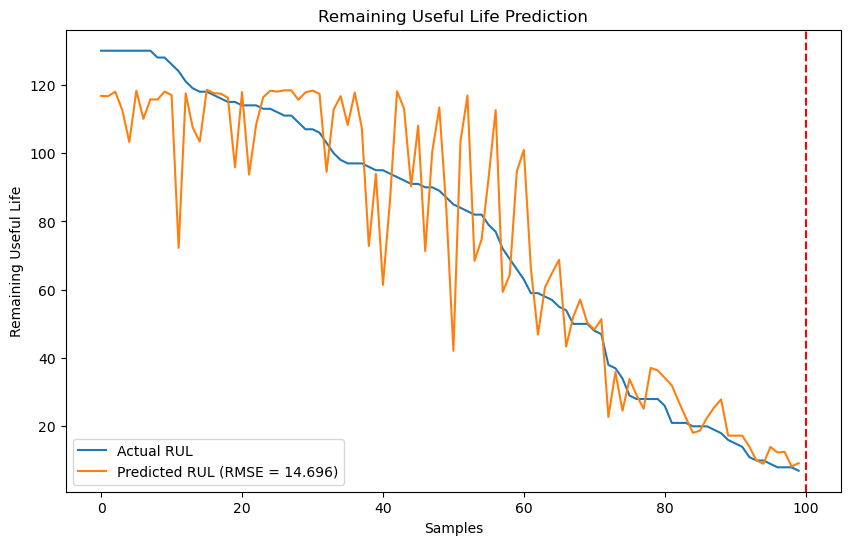

Epoch 61/100 | Training... 100Early stopping


In [ ]:
prev_val_loss = 1000000
for epoch in range(1, N_EPOCH + 1):
    model.train()
    train_loss = 0
    print(f"Epoch {epoch}/{N_EPOCH} | Training...   ", end="")
    for i, (x_padSeq, y_padSeq, original_seq_lens) in enumerate(train_dataLoader):
        print(f"\b\b{(i+1)*BATCH_SIZE:02}", end='')
        optimizer.zero_grad()
        y_pred = model(x_padSeq, original_seq_lens)
        loss_elementwise = loss_fn(y_pred, y_padSeq)
        
        # --- Masked Loss Calculation --- ALL THIS IS BEING DONE TO FACILITATE BATCHING
        # 1. Create the mask (True/1 for non-padded, False/0 for padded)
        max_len = y_pred.size(1) # Get max sequence length from output/target
        # Create range tensor [0, 1, ..., max_len-1] on the correct device
        indices = torch.arange(max_len).expand(x_padSeq.size(0), -1) # Shape: [batch, max_len]
        # Create mask by comparing indices with lengths (broadcast lengths)
        mask = (indices < original_seq_lens.unsqueeze(1)).unsqueeze(-1) # Shape: [batch, max_len] (boolean)

        masked_loss = loss_elementwise * mask
        total_loss = torch.sum(masked_loss)
        # mean_loss = total_loss / torch.sum(mask)  # Mean loss over non-padded elements
        
        total_loss.backward()
        optimizer.step()
        train_loss += total_loss.item()
    train_loss /= len(train_dataLoader.dataset)

    #### VALIDATION ####    
    model.eval()
    val_loss = 0
    val_results = []
    with torch.no_grad():
        for i, (x, y) in enumerate(test_dataLoader):
            y_pred = model(x)
            val_loss = np.add(np.power((y_pred[:, -1, :].item() - y[:, -1, :].item()), 2), val_loss)
            val_results.append(y_pred[:, -1, :].item())
    val_loss = (np.sqrt(val_loss / len(test_dataLoader.dataset))).item()
    
    if val_loss > prev_val_loss and prev_val_loss < 15:
        print("\n--------------- Early stopping -----------------")
        break
    else:
        prev_val_loss = val_loss
        torch.save(model.state_dict(), f'best_model.pth')    
    
    if epoch % 1 == 0:
        print(f" Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")
        # print(f"Test Results: {test_results}")
        if epoch % 5 == 0:
            visualize(val_results, y_test, 100, val_loss)

In [180]:
plot_rul_vs_time(unit_nr=49, model=model, dataloader=test_dataLoader)